In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import wandb
import os
# import click

In [2]:
embeddings = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/MoNA_embeddings_multiple_instrument_types.csv')
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

# Set up WandB:
---

In [3]:
config = {
    'wandb_entity': 'catemerfeld',
    'wandb_project': 'mass_spec',
    'gpu':True,
    'threads':1
}

# Set WANDB_NOTEBOOK_NAME environment variable
os.environ['WANDB_NOTEBOOK_NAME'] = 'denoiser.ipynb'

In [4]:
wandb.finish()

In [5]:
def run_with_wandb(config, **kwargs):
    config.update(kwargs)

    wandb.init(entity=config['wandb_entity'],
               project=config['wandb_project'],
               config=config)

    # Set the number of threads
    torch.set_num_threads(config['threads'])

    # Find out is there is a GPU available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if not config['gpu']:
        device = torch.device('cpu')
    print(f'Using device: {device}')

Using device: cuda


# Function Definitions:
---

In [3]:
def plot_emb_pca(all_embeddings, output_embeddings, output_labels, all_chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    output_transformed = pca.transform(output_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    output_colors = [color_map[chem] for chem in output_labels]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=all_chemical_names,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Denoiser Output')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [4]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [5]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0.5):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:

      numbers = range(0,window)
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'Real {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [44]:
def create_dataset_sections(spectra, embeddings, columns, batch_size=32, noise_loc = None, noise_pct = None, test=False):
  
    """
    Given a list of column names, return a DataLoader object with data for those columns

    Args:
    - spectra (pd.DataFrame): Mass spec data with observations as columns.
    - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - columns (list): Column names to be included in the dataset 
    - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
    - noise_pct (float): percent of noise to introduce to target location
    
    Returns:
    - input_data (DataLoader object): spectrum, encoding information and embedding, labels - chem names
    """
    input_list = []
    true_list = []

    # create lists of spectrum data, condition encoding and chemception embedding with noise as specified in the noise_loc argument
    labels = []

    spectrum_data = spectra[list(columns)][:915].values.copy()
    true_list.append(spectrum_data)
    input_spectra = spectrum_data.copy()
    """
    generate a list of random indices of len = noise_pct% of target location and change 
    values at each index to 0 within either 'spectra', 'condition', or 'embedding'
    """
    if noise_loc == 'spectra':
        for spec in input_spectra:
            noise = noise_pct * len(spec)
            random_numbers = random.sample(range(len(spec)), int(round(noise)))
            for i in random_numbers:
                spec[i] = 0
    input_list.append(input_spectra)

    condition_encodings = spectra[list(columns)][965:977].values.copy()
    true_list.append(condition_encodings)
    input_condition = condition_encodings.copy()
    if noise_loc == 'conditions':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)

    true_embeddings = []
    input_embeddings = []
    for col in columns:
        input_embedding = embeddings[col.split('.')[0]].copy()
        true_embeddings.append(embeddings[col.split('.')[0]].copy())
        if noise_loc == 'embeddings':
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = 0
        if test:
            noise = 1 * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = 0
        input_embeddings.append(input_embedding)
        # label is chemical name encoding
        # labels.append(list(spectra[col][915:-12]))
        labels.append(list(spectra[col][915:965]))
    
    c_ring_encodings = spectra[list(columns)][977:982].values.copy()
    true_list.append(c_ring_encodings)
    input_condition = c_ring_encodings.copy()
    if noise_loc == 'carbon rings':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)

    branch_encodings = spectra[list(columns)][982:].values.copy()
    true_list.append(branch_encodings)
    input_condition = branch_encodings.copy()
    if noise_loc == 'carbon rings':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)
    
    true_list.append(torch.tensor(true_embeddings).T)
    input_list.append(torch.tensor(input_embeddings).T)

    labels = torch.tensor(labels, dtype=torch.float)

    # shifting to make all data positive
    min_value = 1
    input_data = torch.tensor(np.vstack((input_list)).T, dtype=torch.float)
    input_data += min_value
    all_true_vals = torch.tensor(np.vstack((true_list)).T, dtype=torch.float)
    all_true_vals += min_value
    # log transforming data to reduce impact of different scales 
    input_normed = torch.log(input_data)
    trues_normed = torch.log(all_true_vals)
    input_data = TensorDataset(input_normed, trues_normed, labels)

    # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
    input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

    return input_data

In [7]:
def create_dataset(spectra, embeddings, test_chems = ['Succinic Acid'], instrument_idx = 8, batch_size=32, training_chems = None, noise_loc = None, noise_pct = None, test=False):
  """
  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - test_chems (list): List of chemicals to be used as test data
  - instrument_idx (int): Encoded index of instrument to be set aside for testing
  - batch_size (int): Batch size to use for training
  - training_chems (list): When training small group models this param can be used to specify which chems to include in the dataset
  - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
  - noise_pct (float): percent of noise to introduce to target location

  Returns:
    Tuple:
    - train_input (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - test_input (DataLoader object): spectrum, encoding information and embedding, with noise in specified location, labels - chem names
  """

  if noise_loc not in ['spectra', 'embeddings', 'conditions', None]:
    raise ValueError("Invalid value for 'noise_loc'. Please choose from 'spectra', 'embeddings', 'conditions', or None.")
  
  all_test_chem_columns = [col for col in spectra.columns if col.split('.')[0] in test_chems]

  # separate specified chemical and instrument type for testing  
  test_cols = []
  
  if instrument_idx:
    for col in all_test_chem_columns:
      # instrument_encoding = list(spectra[col][-12:])
      instrument_encoding = list(spectra[col][965:977])
      # filter out the test instrument type
      if instrument_encoding.index(1) == instrument_idx:
        test_cols.append(col)
  else:
    test_cols = all_test_chem_columns

  # use either specified chemicals (for small group training) or everything except test cols for training data
  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_input = create_dataset_sections(spectra, embeddings, train_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)
  test_input = create_dataset_sections(spectra, embeddings, test_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct, test=test)

  return train_input, test_input

In [8]:
class Denoiser(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.denoiser = nn.Sequential(
      nn.Linear(1445,1445),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1445,1445),
    )

    self.optimizer = torch.optim.AdamW(self.parameters(), lr = .0001)
    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.denoiser(x)
    return x

In [9]:
def get_loss(model, true_vals, output_0, output_1, output_2, start_idx, end_idx):
    true_data = true_vals[:,start_idx:end_idx]
    output_data_0 = output_0[:, start_idx:end_idx]
    output_data_1 = output_1[:, start_idx:end_idx]
    output_data_2 = output_2[:, start_idx:end_idx]

    m_0_loss = model.criterion(output_data_0, true_data)
    m_1_loss = model.criterion(output_data_1, true_data)
    m_2_loss = model.criterion(output_data_2, true_data)
    loss = m_0_loss + m_1_loss + m_2_loss 
    return loss

In [10]:
def train_denoiser(model, data, test_data, sorted_chemical_names, epochs, train_loss_log = [], test_loss_log = []):
    """
    Args:
    - model (Denoiser): Instantiated Denoiser model.
    - data (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - sorted_chemical_names (list): Sorted list of all chemical names in the training data.
    - epochs (int): Number of epochs to train for.

    Returns:
    - model_output (list): Training data with noisy areas filled in.
    - output_labels (list): Chemical name labels for training data. 
    - true_vals_output (list): Original training data without noise
    """

    model_output = []
    output_labels = []
    true_vals_output = []
    for epoch in range(epochs):
        with torch.no_grad(): 
            test_loss = 0
            for batch, true_vals, labels in test_data:
                output_0= model(batch)
                output_1= model(output_0)
                output_2= model(output_1)
                m_0_loss = model.criterion(output_0, true_vals)
                m_1_loss = model.criterion(output_1, true_vals)
                m_2_loss = model.criterion(output_2, true_vals)

                loss = m_0_loss + m_1_loss + m_2_loss
                test_loss += loss 

            average_test_loss = test_loss/len(test_data)
            
        # accumulate epoch output and loss
        epoch_training_loss = 0
        epoch_spec_loss = 0
        epoch_cond_loss = 0
        epoch_emb_loss = 0
        for batch, true_vals, labels in data:
            output_0= model(batch)
            output_1= model(output_0)
            output_2= model(output_1)
            
            spec_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=0, end_idx=915)
            epoch_spec_loss+=spec_loss
            cond_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=915, end_idx=927)
            epoch_cond_loss+=cond_loss
            emb_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=927, end_idx=1439)
            epoch_emb_loss+=emb_loss

            m_0_loss = model.criterion(output_0, true_vals)
            m_1_loss = model.criterion(output_1, true_vals)
            m_2_loss = model.criterion(output_2, true_vals)
            
            loss = m_0_loss + m_1_loss + m_2_loss
            epoch_training_loss += loss

            # back propogation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (epoch+1)==epochs:
                chem_names = [sorted_chemical_names[list(encoding).index(1)] for encoding in labels]
                for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
                    # undo log transformation
                    denoised_vector = torch.exp(denoised_vector) - 1
                    model_output.append(denoised_vector)
                    true_val = torch.exp(true_val) - 1 
                    true_vals_output.append(true_val)
                    output_labels.append(chem_name)
        

        average_loss = epoch_training_loss/len(data)
        avg_spec_loss = epoch_spec_loss/len(data)
        avg_cond_loss = epoch_cond_loss/len(data)
        avg_emb_loss = epoch_emb_loss/len(data)

        train_loss_log.append(average_loss.detach().numpy())
        test_loss_log.append(average_test_loss.detach().numpy())
        
        if (epoch+1) % 10 == 0:
            print('Epoch[{}/{}], train loss: {}, test loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), round(float(average_test_loss.detach().numpy()), 6)))
            print(f'Spec: {round(float(avg_spec_loss.detach().numpy()), 6)}, Cond: {round(float(avg_cond_loss.detach().numpy()), 6)}, Emb: {round(float(avg_emb_loss.detach().numpy()), 6)}')
            print('--------------------------------------------------------')

    return model_output, output_labels, true_vals_output, train_loss_log, test_loss_log

# Train:
---

In [11]:
# create sorted list of all chemical names in the dataset
all_chemical_names = []
for col in spectra:
    chem = col.split('.')[0]
    if chem not in all_chemical_names:
        all_chemical_names.append(chem)

all_chemical_names = sorted(all_chemical_names)

In [37]:
carbon_rings = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 
                   'Benzyl Alcohol','Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate','Phenanthrene', 'Anthracene', 
                   'Fluorene','Pyrene', 'Testosterone']
branches = ['Succinic Acid', 'Gamma-Amino-N-Butyric Acid', 'Malonic Acid', 'L-Aspartic Acid', 'L-Asparagine', 'Glycylglycine', 'Glutaric Acid', 'Fumaric Acid', 
            'L-Serine', 'Allantoin', '4-Hydroxyphenylpyruvic Acid', 'Beta-Alanine', 'L-Valine', 'L-Ornithine', 'L-Norleucine', 'L-Lysine', 'L-Glutamine', 
            'L-Alanine', 'L-Tyrosine', 'Tryptophan', 'L-Leucine', 'Glycine', 'Glycerol', 'Caffeine', 'Phenanthrene', 'Lauric Acid', 'Benzoic Acid', 'Anthracene', 
            '(5R,11R)-5,11-Dimethylpentacosane', 'Pyrene', 'Fluorene', 'Biphenyl', 'Hexachlorobenzene', 'Benzyl Benzoate', 'Methyl Benzoate', 'Methyl Octadecanoate', 
            'Isopentyl Acetate', 'Methyl Hexanoate', '2-Octanol', 'Benzyl Alcohol', 'Testosterone']
no_rings = [chem for chem in all_chemical_names if not chem in carbon_rings]
no_rings_no_branches = [chem for chem in no_rings if not chem in branches]
no_rings_branches = [chem for chem in no_rings if chem in branches]
rings_branches = [chem for chem in carbon_rings if chem in branches]
print('Chemicals with no rings and no branches:', len(no_rings_no_branches))
print('Chemicals with rings and branches:', len(rings_branches))
print('Chemicals with no rings and branches:', len(no_rings_branches))

Chemicals with no rings and no branches: 8
Chemicals with rings and branches: 15
Chemicals with no rings and branches: 26


In [39]:
one_carbon_ring = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol']
two_carbon_rings = ['Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate']
three_carbon_rings = ['Phenanthrene', 'Anthracene', 'Fluorene']
four_carbon_rings = ['Pyrene', 'Testosterone']
branches = ['Succinic Acid', 'Gamma-Amino-N-Butyric Acid', 'Malonic Acid', 'L-Aspartic Acid', 'L-Asparagine', 'Glycylglycine', 'Glutaric Acid', 'Fumaric Acid', 
            'L-Serine', 'Allantoin', '4-Hydroxyphenylpyruvic Acid', 'Beta-Alanine', 'L-Valine', 'L-Ornithine', 'L-Norleucine', 'L-Lysine', 'L-Glutamine', 
            'L-Alanine', 'L-Tyrosine', 'Tryptophan', 'L-Leucine', 'Glycine', 'Glycerol', 'Caffeine', 'Phenanthrene', 'Lauric Acid', 'Benzoic Acid', 'Anthracene', 
            '(5R,11R)-5,11-Dimethylpentacosane', 'Pyrene', 'Fluorene', 'Biphenyl', 'Hexachlorobenzene', 'Benzyl Benzoate', 'Methyl Benzoate', 'Methyl Octadecanoate', 
            'Isopentyl Acetate', 'Methyl Hexanoate', '2-Octanol', 'Benzyl Alcohol', 'Testosterone']
spectra_new_conditions = {}
for spec in spectra:
    chem = spec.split('.')[0]
    if chem in one_carbon_ring:
        c_rings = pd.Series([0,1,0,0,0])
    elif chem in two_carbon_rings:
        c_rings = pd.Series([0,0,1,0,0])
    elif chem in three_carbon_rings:
        c_rings = pd.Series([0,0,0,1,0])
    elif chem in four_carbon_rings:
        c_rings = pd.Series([0,0,0,0,1])
    else:
        c_rings = pd.Series([0,0,0,0,0])
    
    if chem in branches:
        branch = pd.Series([1])
    else:
        branch = pd.Series([0])
    
    conds = pd.concat([c_rings, branch])
    data = pd.concat([spectra[spec], conds], ignore_index=True)
    spectra_new_conditions[spec] = data

spectra_new_conditions = pd.DataFrame(spectra_new_conditions)

In [45]:
rings = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol',
        'Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate', 'Phenanthrene', 'Anthracene', 'Fluorene', 'Pyrene', 'Testosterone']
no_rings = [chem for chem in all_chemical_names if not chem in rings]
len(no_rings)
chems = [chem for chem in four_carbon_rings if not chem in branches]
# print(len(four_carbon_rings))
# len(chems)
no_branches = [chem for chem in all_chemical_names if not chem in branches]
len(no_branches)

9

In [147]:
ring_no_branch = [chem for chem in rings if not chem in branches]
ring_no_branch

['Naphthalene']

In [64]:
no_rings_no_branches

['1,3-Diaminopropane',
 '1,4-Butanediamine',
 '1-Hexanol',
 '1-Octanol',
 'Ethanolamine',
 'Pentadecane',
 'Spermidine',
 'Undecane']

In [103]:
loss_type = 'spectra'
# test_chems = ['Caffeine', 'Biphenyl', 'Benzyl Benzoate']
# test_chems = ['Naphthalene']
test_chems = no_rings_no_branches
# training on all chemicals except test chem and other chemical in the 3 rings w/branches group
train_chems = all_chemical_names.copy()
for chem in test_chems:
    train_chems.remove(chem)
noise_pct = .8
# test = False
test=True
# test_chems = ['Benzyl Benzoate']
# train_noisy_data, test_noisy_data = create_dataset(spectra_new_conditions, embeddings, noise_loc=loss_type, noise_pct=noise_pct, training_chems=train_chems, test_chems=test_chems, instrument_idx=None)
train_noisy_data, test_noisy_data = create_dataset(spectra_new_conditions, embeddings, noise_loc=loss_type, noise_pct=noise_pct, training_chems=train_chems, test_chems=test_chems, instrument_idx=None, test=test)

In [104]:
denoiser = Denoiser()
model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=100, train_loss_log = [], test_loss_log = [])

Epoch[10/100], train loss: 0.191355, test loss: 0.455628
Spec: 0.262651, Cond: 0.072289, Emb: 0.067978
--------------------------------------------------------
Epoch[20/100], train loss: 0.143522, test loss: 0.445327
Spec: 0.207746, Cond: 0.06667, Emb: 0.03175
--------------------------------------------------------
Epoch[30/100], train loss: 0.116928, test loss: 0.442721
Spec: 0.172083, Cond: 0.057947, Emb: 0.02082
--------------------------------------------------------
Epoch[40/100], train loss: 0.101745, test loss: 0.444195
Spec: 0.150259, Cond: 0.054136, Emb: 0.017114
--------------------------------------------------------
Epoch[50/100], train loss: 0.088661, test loss: 0.450452
Spec: 0.131428, Cond: 0.050557, Emb: 0.013969
--------------------------------------------------------
Epoch[60/100], train loss: 0.078827, test loss: 0.443904
Spec: 0.117131, Cond: 0.046264, Emb: 0.011898
--------------------------------------------------------
Epoch[70/100], train loss: 0.072367, test l

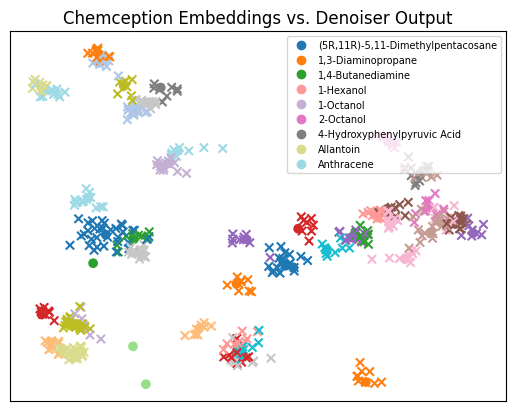

In [90]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

# Test:
---

In [105]:
denoiser.eval()
test_output = []
test_labels = []
test_true_values = []
test_loss = 0

with torch.no_grad(): 
    for batch, true_vals, labels in test_noisy_data:
        output_0= denoiser(batch)
        output_1= denoiser(output_0)
        output_2= denoiser(output_1)

        m_0_loss = denoiser.criterion(output_0, true_vals)
        m_1_loss = denoiser.criterion(output_1, true_vals)
        m_2_loss = denoiser.criterion(output_2, true_vals)

        loss = m_0_loss + m_1_loss + m_2_loss
        test_loss+=loss

        chem_names = [all_chemical_names[list(encoding).index(1)] for encoding in labels]
        for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
            # undo log transformation
            denoised_vector = torch.exp(denoised_vector) - 1
            test_output.append(denoised_vector)
            true_val = torch.exp(true_val) - 1 
            test_true_values.append(true_val)
            test_labels.append(chem_name)

    average_loss = test_loss/len(test_noisy_data)
    print('Loss =', average_loss)

Loss = tensor(0.4453)


Weighted cosine similarity is:  0.14


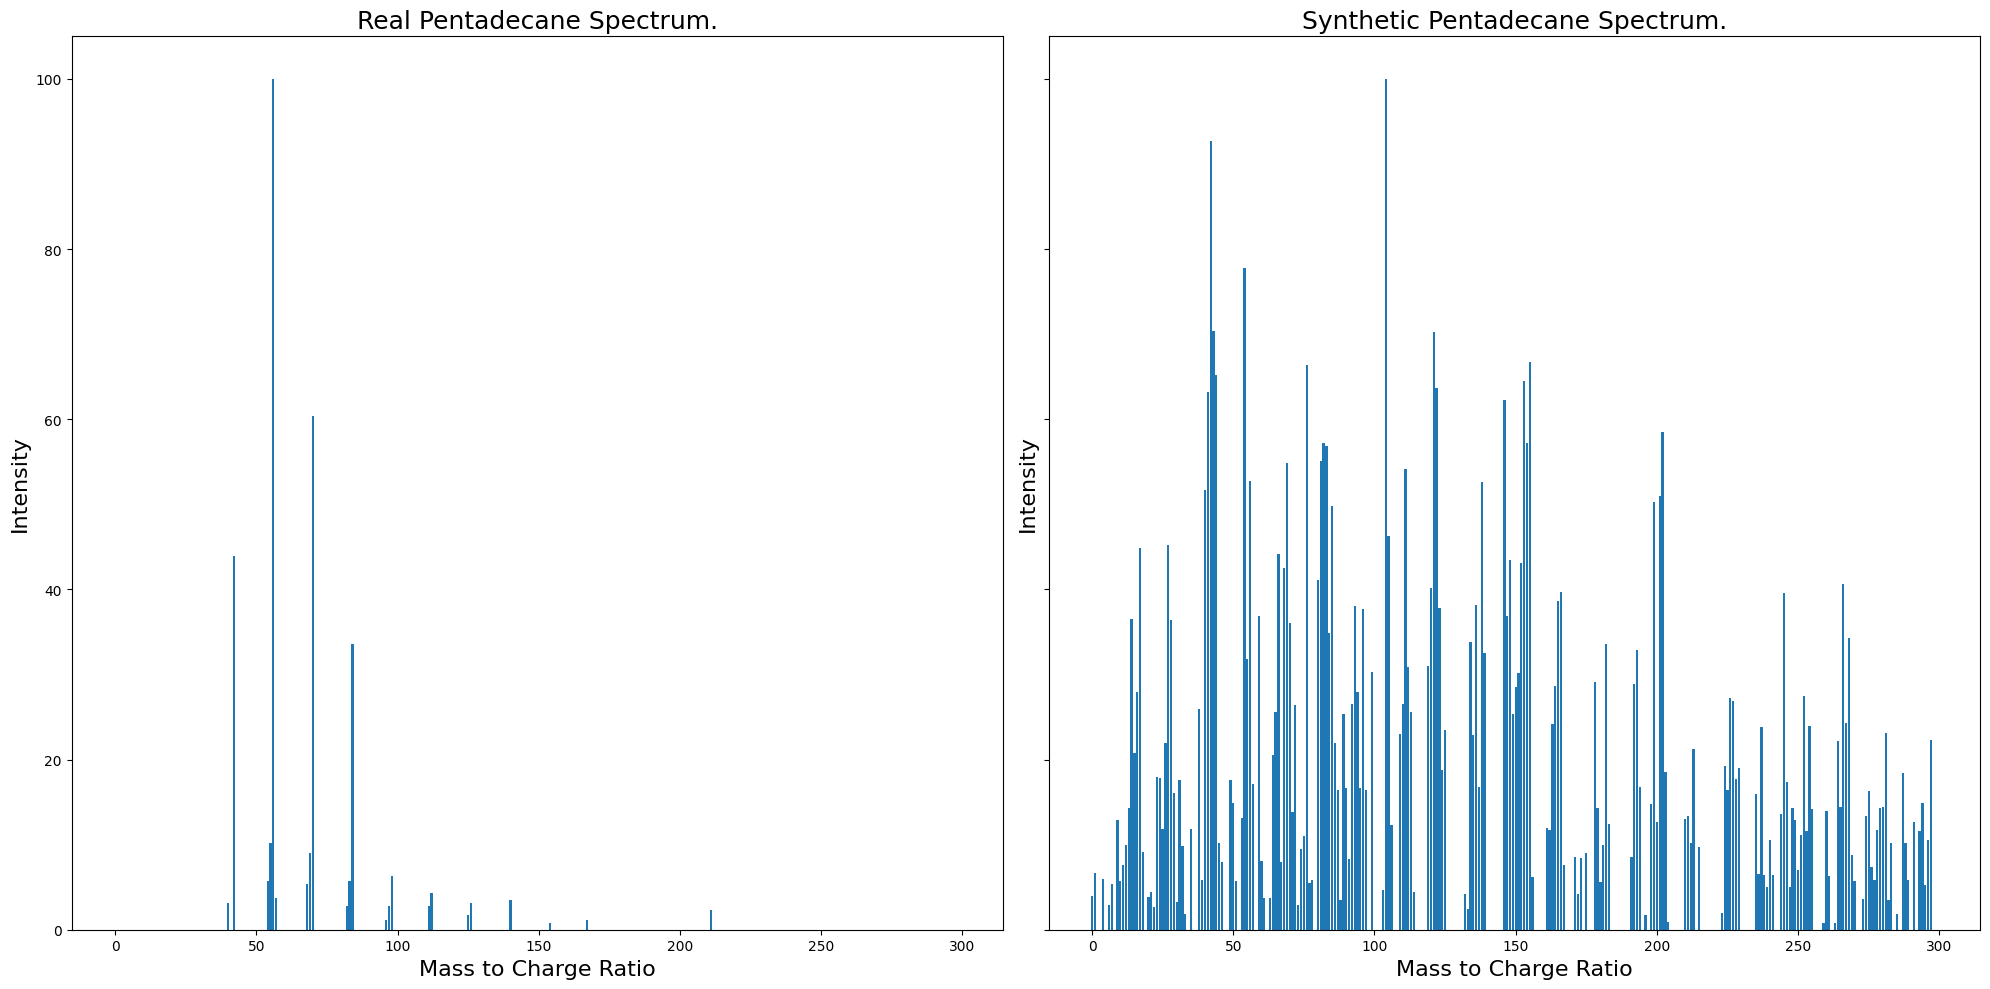

Weighted cosine similarity is:  0.2


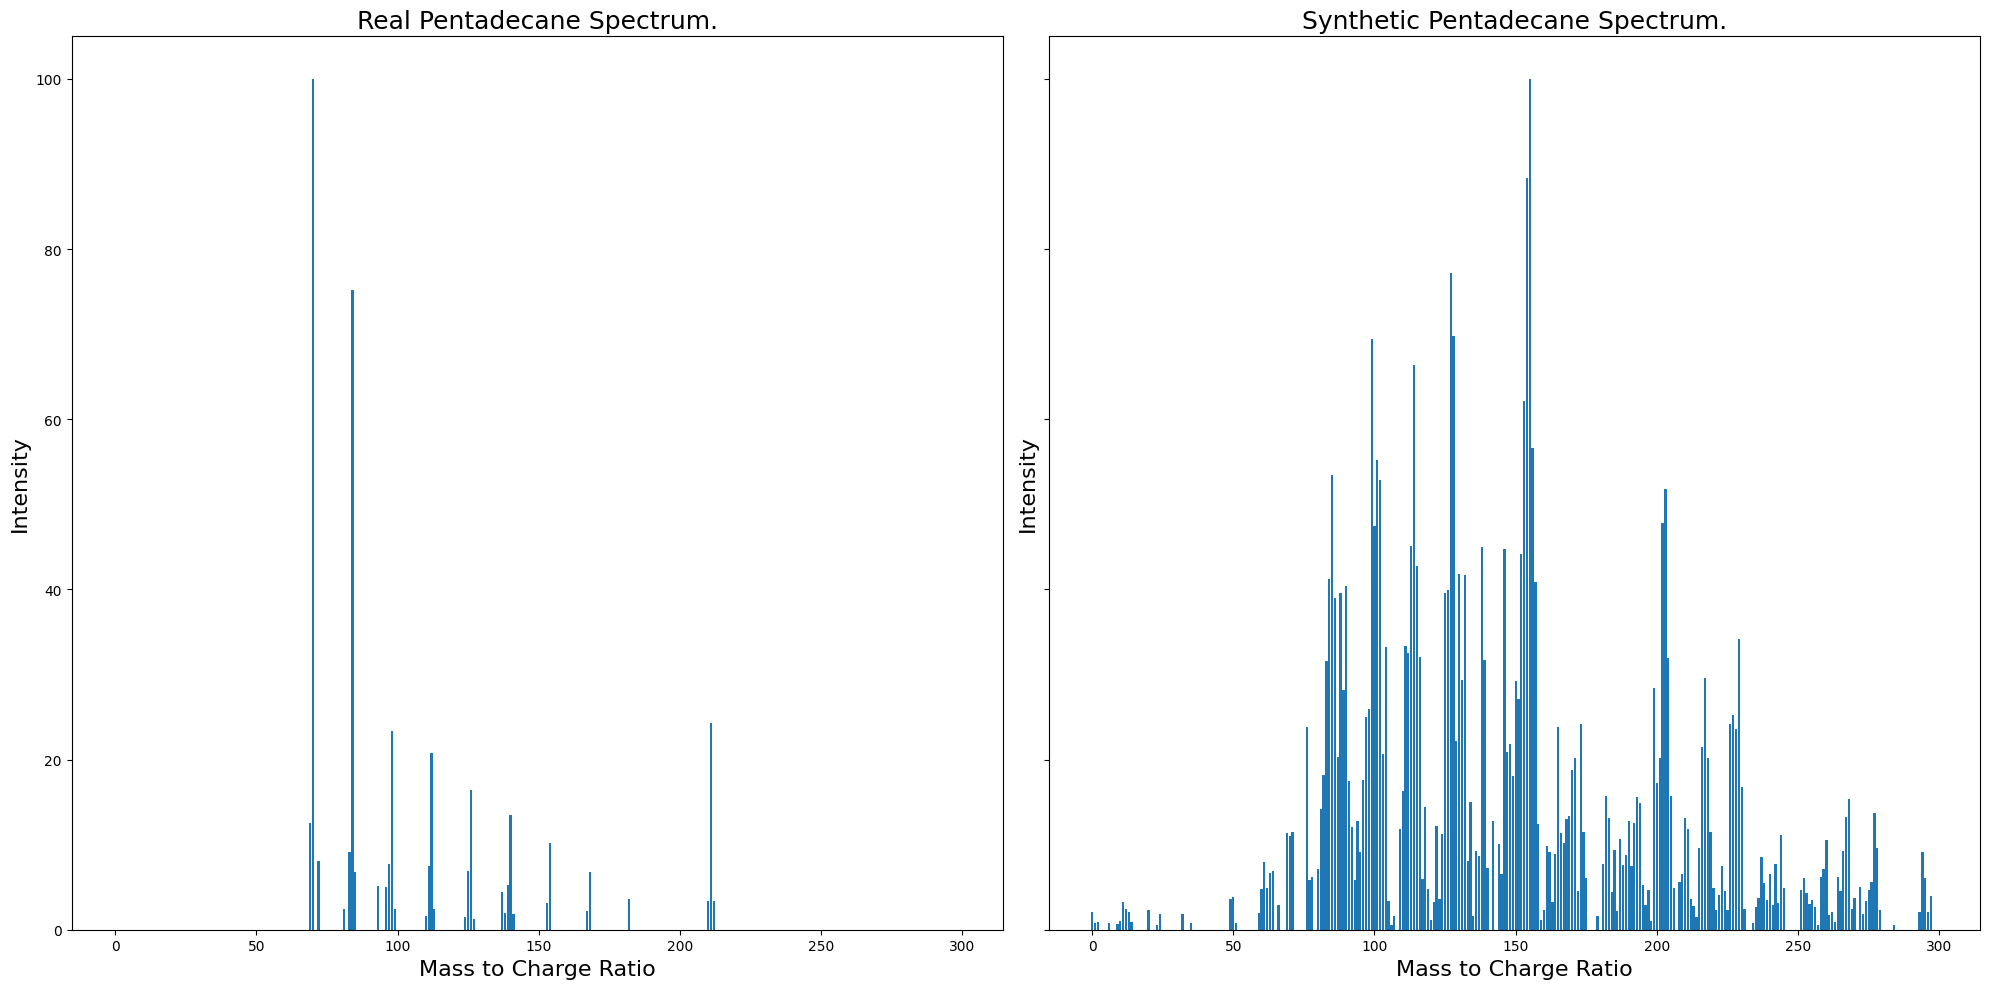

Weighted cosine similarity is:  0.57


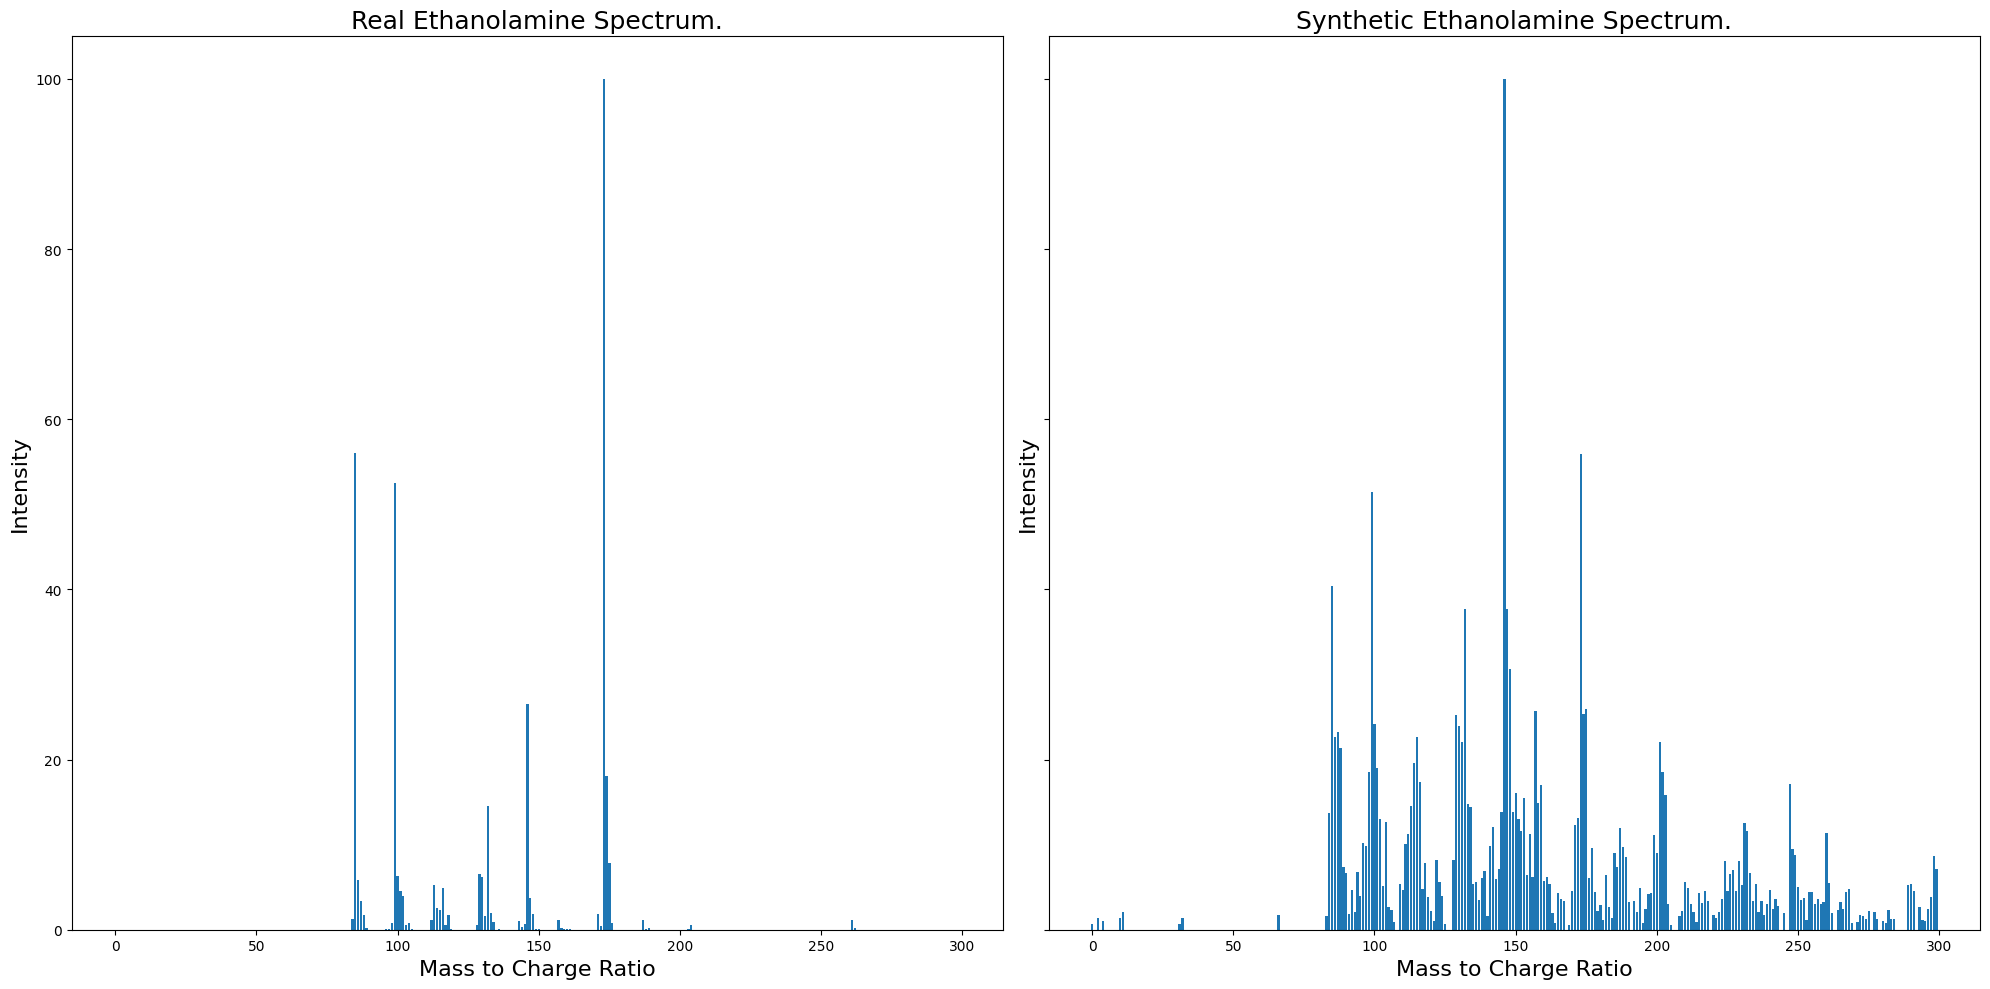

In [106]:
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
output_spectra = [vec[:915].detach().numpy() for vec in test_output]
plot_results(true_spectra, output_spectra, test_labels, idx=[0,3])

In [ ]:
# get values for test spectra 
spec_num = 0
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
fake_spec = true_spectra[spec_num]
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
# fake_spec = output_spectra[spec_num]
max_val = max(fake_spec)
scaled_spec = [num/max_val * 100 for num in fake_spec]
scaled_spec = [num if num >= 0 else 0 for num in scaled_spec]
threshold = 0.5
x = []
y = []
for i, num in enumerate(scaled_spec):
  if num > threshold:
    x.append(num)
    y.append(i+1)

In [107]:
# get values for test spectra 
spec_num = 0
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
fake_spec = true_spectra[spec_num]
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
# fake_spec = output_spectra[spec_num]
max_val = max(fake_spec)
scaled_spec = [num/max_val * 100 for num in fake_spec]
scaled_spec = [num if num >= 0 else 0 for num in scaled_spec]
threshold = 0.5
for i, num in enumerate(scaled_spec):
  if num > threshold:
    print(i+1, round(float(num), 4))

41 3.1203
43 43.9344
55 5.7106
56 10.151
57 100.0
58 3.7204
69 5.4305
70 8.9609
71 60.4261
83 2.8303
84 5.7506
85 33.5434
97 1.1101
98 2.8303
99 6.3706
112 2.8403
113 4.3504
126 1.7602
127 3.1203
141 3.4603
155 0.8301
168 1.1201
212 2.3502


# Dataset Exploration:
---

In [19]:
def plot_spectra_pca(all_spectra, chemical_names):
    """
    Run pca on spectra from the dataset and plot the output.

    Args:
    - all_spectra (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    # - all_spectra (list): All spectra in dataset.
    # - plotting_spectra (list): Spectra to be plotted.
    - chemical_names (list): List of names of chemicals to be plotted.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_spectra.T)

    # get a list of columns for the chemicals we want to plot
    cols = [col for col in all_spectra.columns if col.split('.')[0] in chemical_names]
    plotting_spectra = [all_spectra[chem] for chem in cols] 
    chemical_names = [col.split('.')[0] for col in cols]
    
    true_transformed = pca.transform(plotting_spectra)

    color_map = {chem: idx for idx, chem in enumerate(set(chemical_names))}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in chemical_names]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=set(chemical_names),
                loc='upper right',
                prop={'size':7})


    plt.title('Spectra PCA')
    plt.xticks([])
    plt.yticks([])

    plt.show()

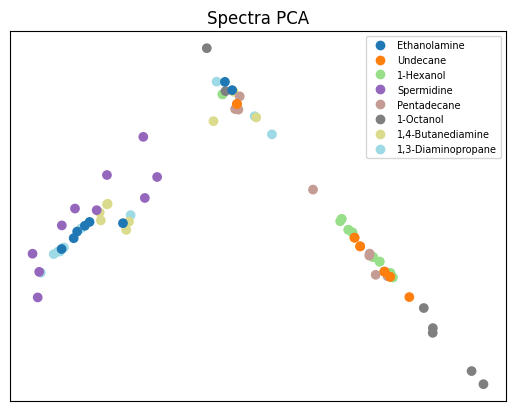

In [30]:
# chemical_names = ['Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate', '1,3-Diaminopropane', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Pentadecane', 'Spermidine', 'Undecane']
# chemical_names = ['Anthracene', 'Caffeine', 'Biphenyl', 'Benzyl Benzoate','1,3-Diaminopropane', 'Hexachlorobenzene', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Naphthalene', 'Pentadecane', 'Spermidine', 'Undecane']
chemical_names = ['1,3-Diaminopropane', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Pentadecane', 'Spermidine', 'Undecane']
plot_spectra_pca(spectra, chemical_names)

In [135]:
all_chemical_names.index('Fluorene')

16

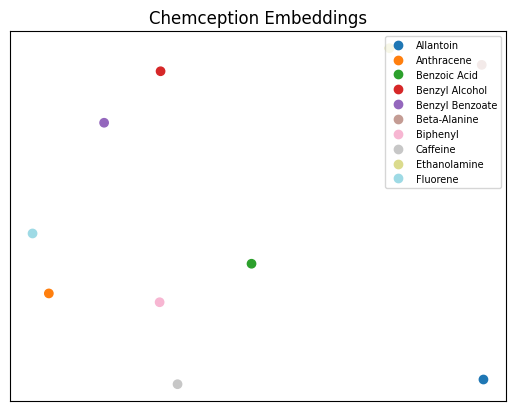

In [136]:
# included_chems = ['Anthracene', 'Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol', 'Naphthalene']
included_chems = ['Anthracene', 'Caffeine', 'Biphenyl', 'Benzyl Benzoate','1,3-Diaminopropane', 'Hexachlorobenzene', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Naphthalene', 'Pentadecane', 'Spermidine', 'Undecane']
output_embeddings = []
included_labels = []

for vec, label in zip(model_output, output_labels):
    if label in included_chems:
        output_embeddings.append(vec[-512:].detach().numpy())
        included_labels.append(label)

# 7-17 includes anthracene and fluorene
plot_chemception_embeddings(embeddings, all_chemical_names[7:17])

# Plot condition embeddings:
---

In [54]:
def plot_cond_emb_pca(all_embeddings, output_embeddings, output_labels, all_chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    output_transformed = pca.transform(output_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    # unique_labels = sorted(list(set(output_labels)))
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    # plt.scatter(output_x, output_y, marker='x', s=1000, c=output_colors, cmap='tab20')
    
    # one_ring = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol']
    # for chem in one_ring:
    #     i = output_labels.index(chem)
    #     plt.scatter(output_x[i], output_y[i], marker='o', s=250, facecolors = 'none', edgecolors='r')

    two_rings = ['Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate']
    for chem in two_rings:
        i = output_labels.index(chem)
        plt.scatter(output_x[i], output_y[i], marker='o', s=400, facecolors = 'none', edgecolors='k')

    # three_rings = ['Phenanthrene', 'Anthracene', 'Fluorene']
    # for chem in three_rings:
    #     i = output_labels.index(chem)
    #     plt.scatter(output_x[i], output_y[i], marker='o', s=250, facecolors = 'none', edgecolors='b')

    no_branches = ['1,3-Diaminopropane', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Naphthalene', 'Pentadecane', 'Spermidine', 'Undecane']
    for chem in no_branches:
        i = output_labels.index(chem)
        plt.scatter(output_x[i], output_y[i], marker='o', s=200, facecolors = 'none', edgecolors='r')

    # plt.scatter(output_x[i], output_y[i], marker='o', s=1000, facecolors = 'none', edgecolors='k')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=output_labels,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [66]:
def plot_cond_emb_pca(all_embeddings, condition_embeddings, all_chemical_names, cond_1_list, cond_2_list):
    """
    Run pca on Chemception embeddings and label specific conditions.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - condition_embeddings (list): Chemception embeddings for desired chemicals.
    - all_chemical_names (list): Sorted list of all chemical names to be plotted.
    - cond_1_list (list): Sorted list of chemical names for condition 1.
    - cond_2_list (list): Sorted list of chemical names for condition 2.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    condition_transformed = pca.transform(condition_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]

    x = [pair[0] for pair in condition_transformed]
    y = [pair[1] for pair in condition_transformed]
    scatter = plt.scatter(x, y, c=true_colors, cmap='tab20')

    for chem in cond_1_list:
        i = all_chemical_names.index(chem)
        plt.scatter(x[i], y[i], marker='o', s=400, facecolors = 'none', edgecolors='k')

    for chem in cond_2_list:
        i = all_chemical_names.index(chem)
        plt.scatter(x[i], y[i], marker='o', s=200, facecolors = 'none', edgecolors='r')


    plt.legend(handles=scatter.legend_elements()[0],
                labels=all_chemical_names,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings')
    plt.xticks([])
    plt.yticks([])

    plt.show()

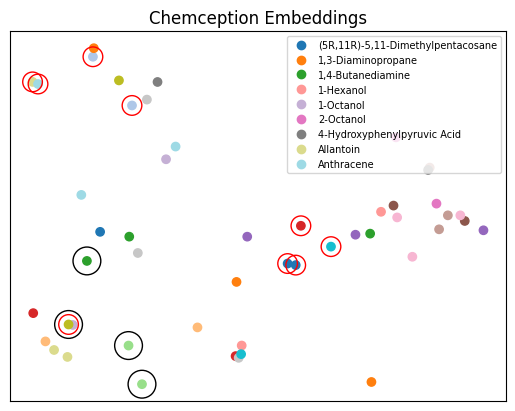

In [89]:
plotting_labels = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol', 'Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate']
new_df = embeddings[plotting_labels]
plotting_embeddings = []

for chem in plotting_labels:
    plotting_embeddings.append(embeddings[chem])

all_embeddings = []
for chem in all_chemical_names:
    all_embeddings.append(embeddings[chem])



two_rings = ['Caffeine', 'Biphenyl', 'Naphthalene', 'Benzyl Benzoate']
no_branches = ['1,3-Diaminopropane', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Naphthalene', 'Pentadecane', 'Spermidine', 'Undecane']

plot_cond_emb_pca(embeddings, all_embeddings, all_chemical_names, two_carbon_rings, no_branches)

In [21]:
def plot_chemception_embeddings(all_embeddings, chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - chemical_names (list): Sorted list of chemical names in the training data.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in chemical_names]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')
    # scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')
    # for i, (x, y) in enumerate(zip(true_x,true_y)):
    #     plt.scatter(x, y, c=true_colors[i], label=all_chemical_names[i], cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=chemical_names,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings')
    plt.xticks([])
    plt.yticks([])

    plt.show()

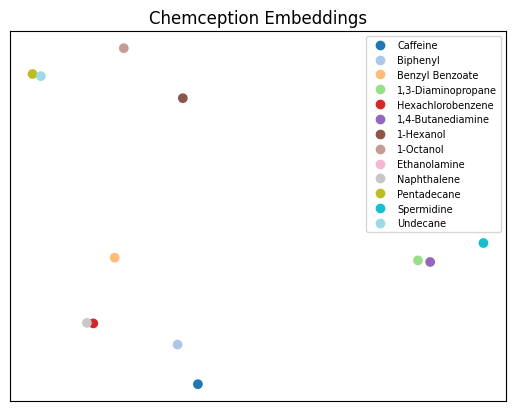

In [93]:
# included_chems = ['Allantoin', '4-Hydroxyphenylpyruvic Acid','L-Tyrosine', 'Benzoic Acid', 'Hexachlorobenzene', 'Methyl Benzoate', 'Benzyl Alcohol', 'Naphthalene']
included_chems = ['Caffeine', 'Biphenyl', 'Benzyl Benzoate','1,3-Diaminopropane', 'Hexachlorobenzene', '1,4-Butanediamine', '1-Hexanol', '1-Octanol', 'Ethanolamine', 'Naphthalene', 'Pentadecane', 'Spermidine', 'Undecane']
output_embeddings = []
included_labels = []

for vec, label in zip(model_output, output_labels):
    if label in included_chems:
        output_embeddings.append(vec[-512:].detach().numpy())
        included_labels.append(label)

plot_chemception_embeddings(embeddings, included_chems)

In [27]:
# true_spectra = [vec[:300].detach().numpy() for vec in true_values]
# output_spectra = [vec[:300].detach().numpy() for vec in model_output]
# plot_results(true_spectra, output_spectra, output_labels, idx=[15,17])

Weighted cosine similarity is:  -0.0


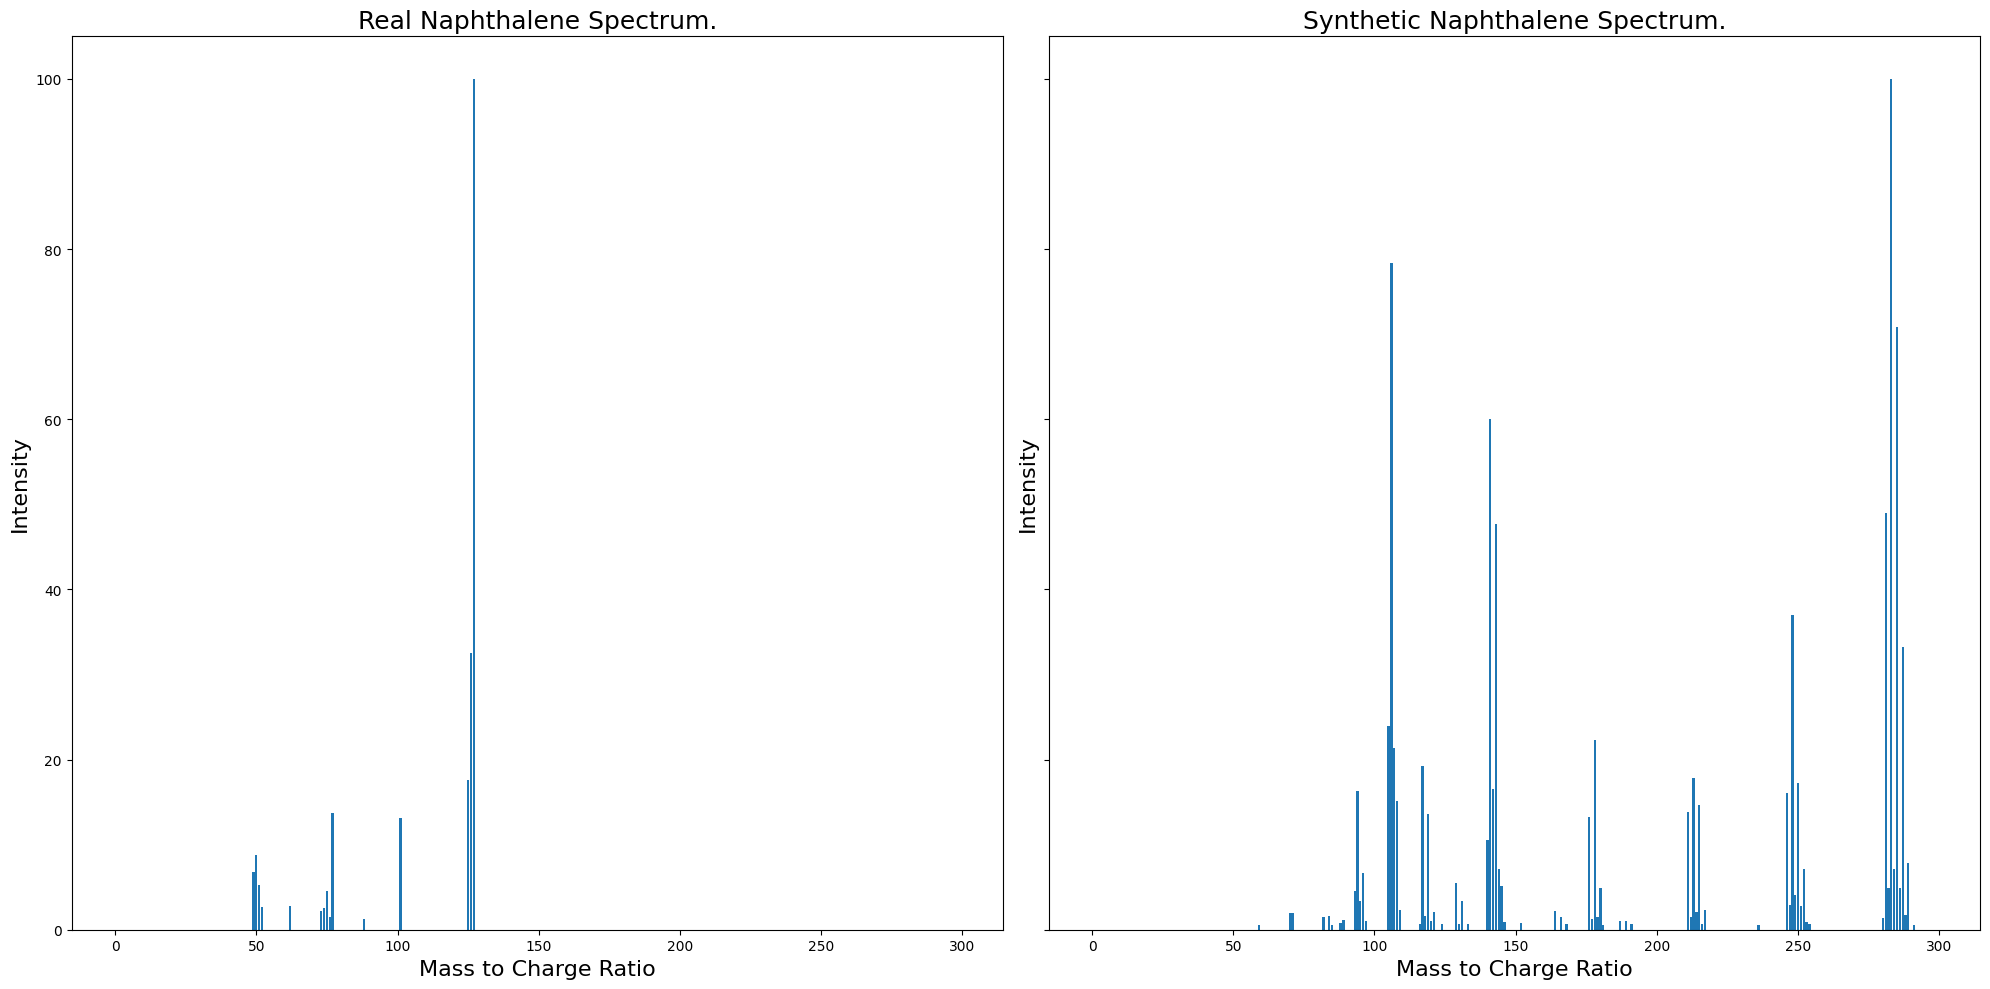

Weighted cosine similarity is:  0.01


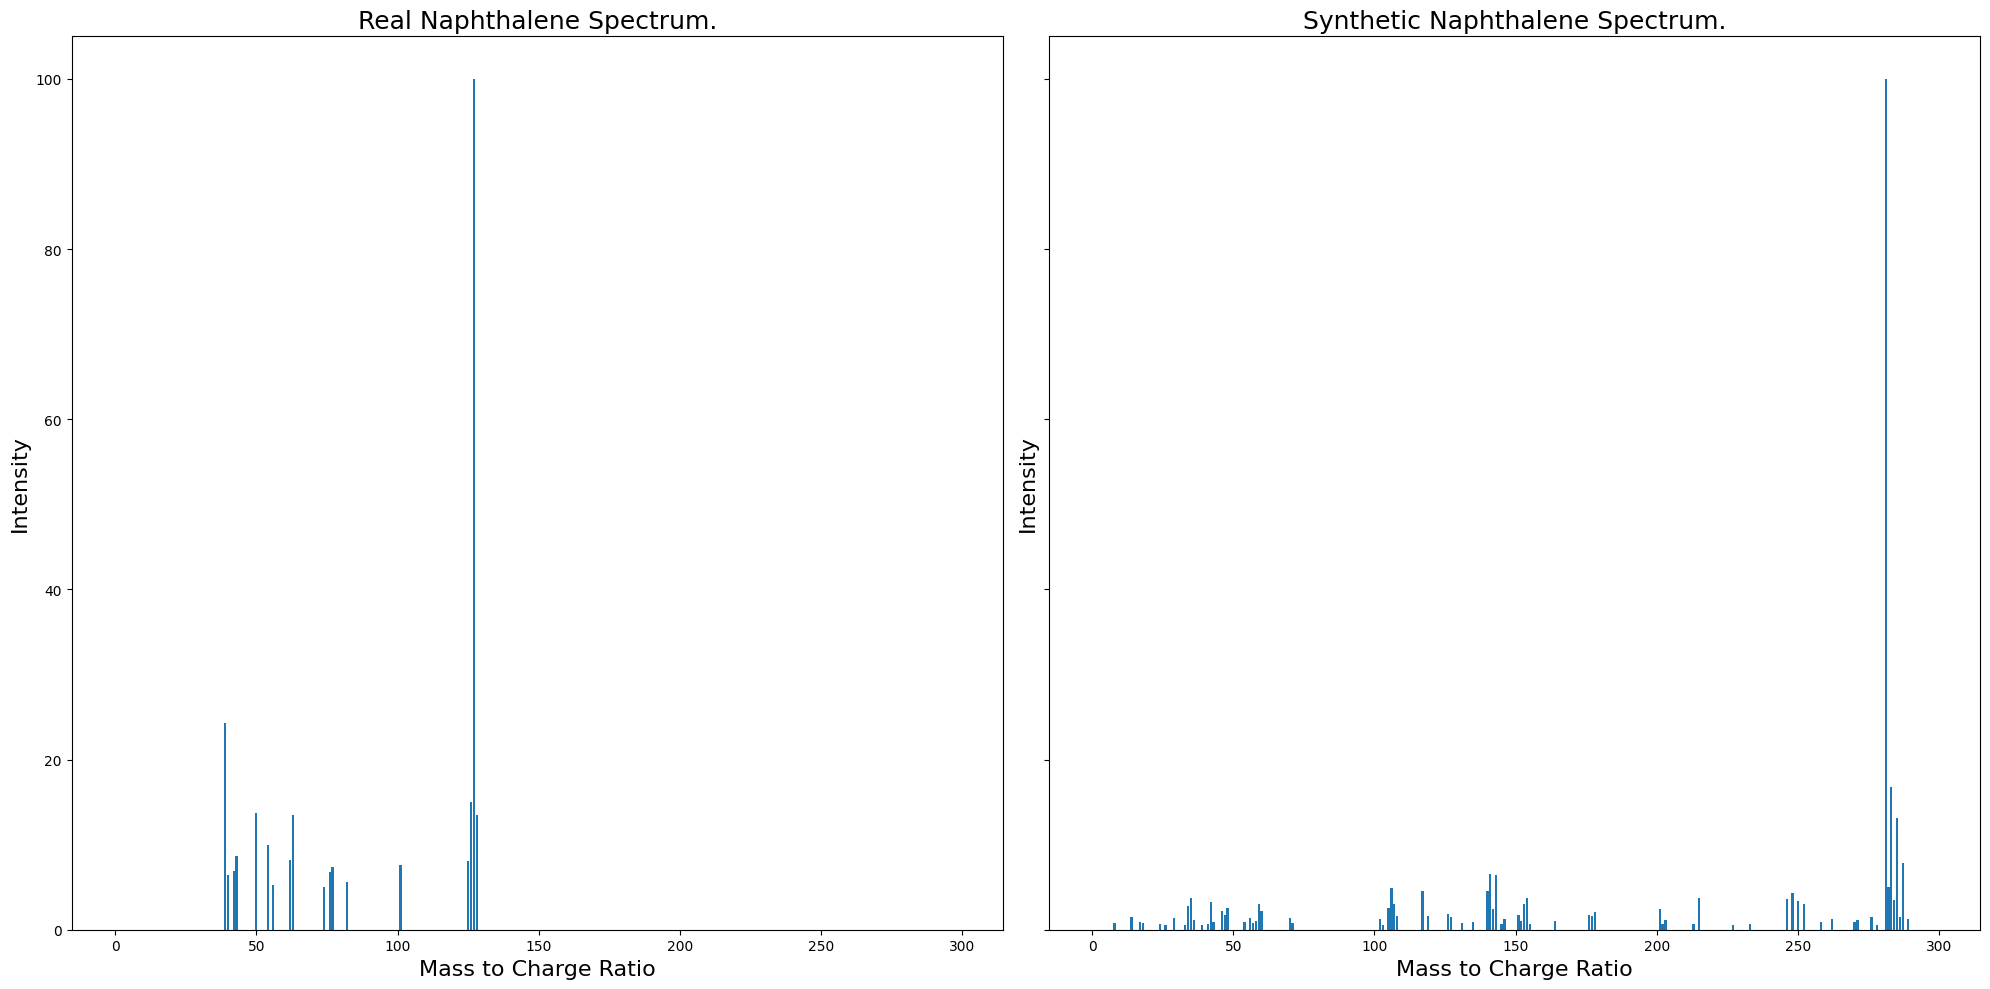

Weighted cosine similarity is:  -0.0


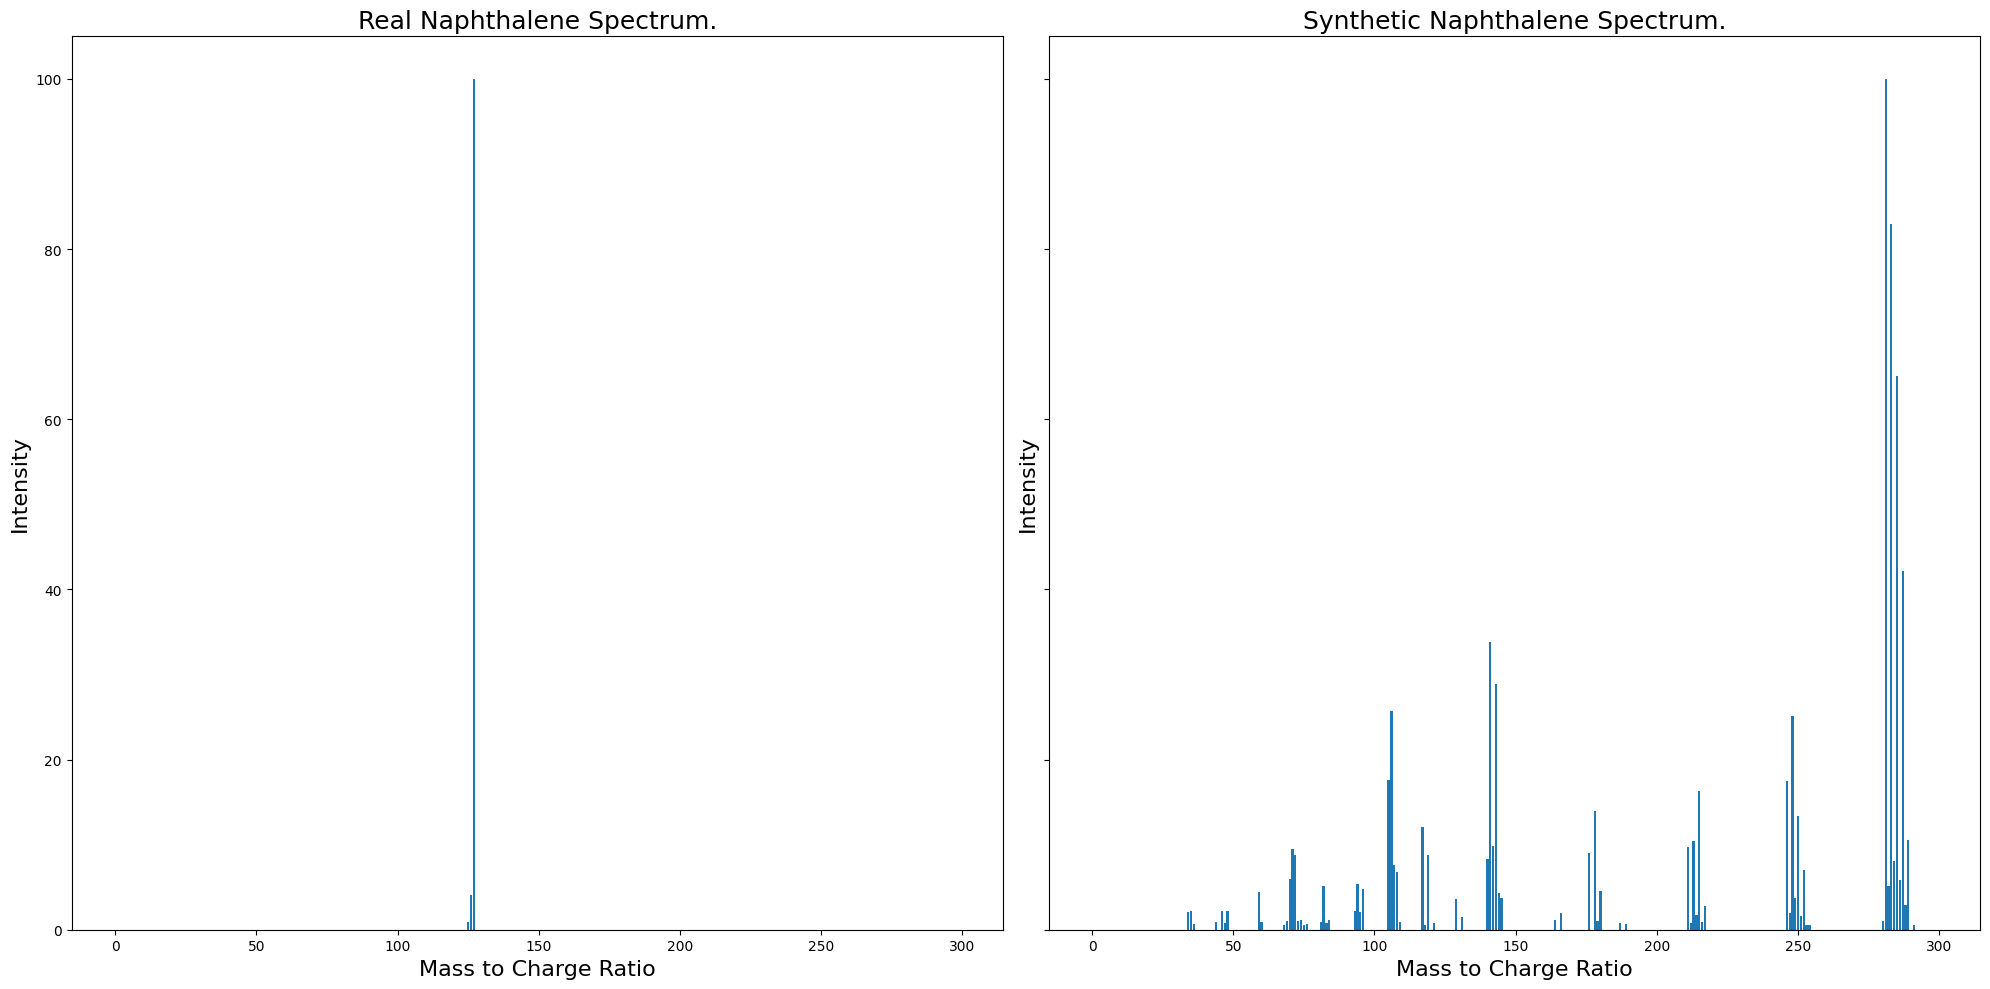

In [51]:
included_chems = ['Hexachlorobenzene']

comparison_spectra = []

for vec, label in zip(model_output, output_labels):
    if label in included_chems:
        comparison_spectra.append(vec)

comparison_spectra = [vec[:915].detach().numpy() for vec in comparison_spectra]
output_spectra = [vec[:915].detach().numpy() for vec in test_output]
plot_results(true_spectra, comparison_spectra, test_labels, idx=[0,3])

In [ ]:
# test_output_embeddings = [vec[-512:].detach().numpy() for vec in test_output]
# # plot_emb_pca(embeddings, test_output_embeddings, test_labels, train_chems)
# plot_emb_pca(embeddings, test_output_embeddings, test_labels, all_chemical_names)

In [107]:
# get values for test spectra 
spec_num = 0
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
fake_spec = true_spectra[spec_num]
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
# fake_spec = output_spectra[spec_num]
max_val = max(fake_spec)
scaled_spec = [num/max_val * 100 for num in fake_spec]
scaled_spec = [num if num >= 0 else 0 for num in scaled_spec]
threshold = 0.1
for i, num in enumerate(scaled_spec):
  if num > threshold:
    print(i+1, round(float(num), 4))

40 24.2924
41 6.4506
43 6.8807
44 8.6709
51 13.6614
55 9.911
57 5.3005
63 8.1708
64 13.5114
75 5.0305
77 6.8207
78 7.3807
83 5.5506
102 7.6408
126 8.1008
127 15.0215
128 100.0
129 13.4713


# Generate embeddings and then spectra:
---

In [ ]:
# train_data = []
# true_data = []
# for true_val, pred_val in zip(true_values, model_output):
#     train_data_point = true_val
#     for i in enumerate(train_data_point[927:]):
#         train_data_point[i[0]+927] = pred_val[i[0]+927]
#     train_data.append(train_data_point.detach().clone().numpy())
#     true_data.append(true_val.detach().clone().numpy())
    
# # shifting to make all data positive
# min_value = 1
# input_data = torch.tensor(np.vstack((train_data)).T, dtype=torch.float)
# input_data += min_value
# all_true_vals = torch.tensor(np.vstack((true_data)).T, dtype=torch.float)
# all_true_vals += min_value
# # log transforming data to reduce impact of different scales 
# input_normed = torch.log(input_data)
# trues_normed = torch.log(all_true_vals)
# input_data = TensorDataset(input_normed, trues_normed, output_labels)

# batch_size=32
# # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
# input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

In [100]:
# relevant_chems = [chem for chem in all_chemical_names if not chem in branches]
# relevant_chems += [chem for chem in ['Caffeine', 'Biphenyl', 'Benzyl Benzoate'] if not chem in relevant_chems]
# relevant_embeddings = [embeddings[chem] for chem in relevant_chems]
# # len(relevant_embeddings)
# # avg_embedding = np.array(embeddings[relevant_chems].mean())
# # len(avg_embedding)
# total = []
# for i in len(relevant_embeddings[0]):
    